In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os


In [15]:
path = 'dataset/'
classes = ['with_mask', 'without_mask']

In [17]:
augmentasi = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest",
	validation_split=0.2)

In [20]:
train_dataset = augmentasi.flow_from_directory(batch_size=64,
                                                 directory='dataset/',
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="training",
                                                 class_mode='categorical',
                                                 classes = classes
                                                 )
validation_dataset = augmentasi.flow_from_directory(batch_size=64,
                                                 directory='dataset/',
                                                 shuffle=True,
                                                 target_size=(224, 224), 
                                                 subset="validation",
                                                 class_mode='categorical',
                                                 classes = classes
                                                 )


Found 3067 images belonging to 2 classes.
Found 766 images belonging to 2 classes.


In [21]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [24]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [26]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [28]:
opt = Adam(lr=1e-4, decay= 1e-4/ 20)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

c:\Users\Computer\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [31]:
# callback membantu proses training agar lebih efisien, mulai dari early stop, check point, sampai dengan custom callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from keras.callbacks import EarlyStopping


# modelFolder = 'model[0]/' #merupakan folder model yang menggunakan arsitektur neural network squensial,
modelFolder = 'model[5]/' # merupakan folder model yang mengunakan arsitektur inception neural network v2

# checkpoint ini memungkinkan weight disimpan pada saat loss training mencapai titik minimum
checkpointLoss = ModelCheckpoint(f"{modelFolder}bestLoss.hdf5", 
                            monitor='loss', 
                            verbose=1,
                            save_best_only=True, 
                            mode='auto')

# checkpoint ini memungkinkan weight disimpan pada saat loss training pada tahap validation mencapai titik minimum
checkpointValLoss = ModelCheckpoint(f"{modelFolder}bestValLoss.hdf5", 
                            monitor='val_loss', 
                            verbose=1,
                            save_best_only=True, 
                            mode='auto')

# checkpoint early stop memungkinkan model untuk langsung berhenti melakukan proses training ketika
# tidak terdapat penurunan loss (semakin kecil locc semakin bagus). 
# patience = 10, menandakan model akan berhenti ketika tidak ada lagi minimum loss yang didapatkan selama 10 epochs berturut turut
earlyStopVal = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
earlyStop = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=10)

# callback khusus yang akan langsung memberhentikan model ketika sudah mencapain akurasi dan loss yang cukup, yakni 95% akurasi dengan loss 0.001
class myCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95 and logs.get('loss')<0.001):
            print("\nAkurasi telah mencapai > 95%! dan loss < 0.001")
            self.model.stop_training = True

callbacks = myCallback()

In [39]:
epoch = 20
H = model.fit(
    train_dataset,
    epochs= epoch,
    validation_data=validation_dataset
    )

Epoch 1/20
48/48 [==============================] - 328s 7s/step - loss: 0.4455 - accuracy: 0.8168 - val_loss: 0.3652 - val_accuracy: 0.8708
Epoch 2/20
48/48 [==============================] - 348s 7s/step - loss: 0.4113 - accuracy: 0.8363 - val_loss: 0.3442 - val_accuracy: 0.8877
Epoch 3/20
48/48 [==============================] - 367s 8s/step - loss: 0.3808 - accuracy: 0.8543 - val_loss: 0.3442 - val_accuracy: 0.8681
Epoch 4/20
48/48 [==============================] - 889s 19s/step - loss: 0.3729 - accuracy: 0.8572 - val_loss: 0.3537 - val_accuracy: 0.8668
Epoch 5/20
48/48 [==============================] - 682s 14s/step - loss: 0.3531 - accuracy: 0.8611 - val_loss: 0.3251 - val_accuracy: 0.8799
Epoch 6/20
48/48 [==============================] - 540s 11s/step - loss: 0.3512 - accuracy: 0.8543 - val_loss: 0.3058 - val_accuracy: 0.8930
Epoch 7/20
48/48 [==============================] - 380s 8s/step - loss: 0.3266 - accuracy: 0.8693 - val_loss: 0.3002 - val_accuracy: 0.8825
Epoch 8/20

In [40]:
train_loss, train_accu = model.evaluate(train_dataset)
test_lost, test_accu = model.evaluate(validation_dataset)
print("final train accuracy = {:.2f}, validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

12/12 [==============================] - 71s 6s/step - loss: 0.2420 - accuracy: 0.9034
final train accuracy = 91.16, validation accuracy = 90.34


In [42]:
model.save_weights('91_90.h5')

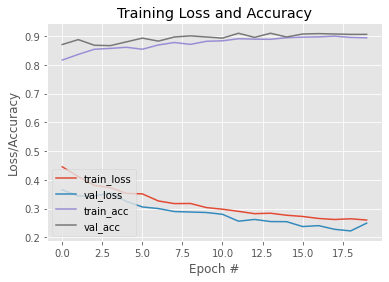

In [43]:
N = epoch
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")